In [1]:
import sys
sys.path.append('..')

import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import optuna

from eli5.sklearn import PermutationImportance

from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = True
    optimize = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

# Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000
load = False 

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

# Check if all dataframes has data for both timeframes 1h and 4h

In [4]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare data

In [5]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    df.ffill(inplace=True)
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # MinMax scale price and volume columns
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set sl flag and exit cycle if price crosses stop-loss threshold before it crosses take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1
                sl3 = pattern.startswith('Pattern') and ttype == 'buy' and target_sell_sl == 1
                sl4 = pattern.startswith('Pattern') and ttype == 'sell' and target_buy_sl == 1
                
                if sl1 or sl2 or sl3 or sl4:
                    break

                # set tp flag and exit cycle if price cross take-profit threshold and doesn't cross stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                tp3 = pattern.startswith('Pattern') and ttype == 'buy' and target_buy_tp == 1
                tp4 = pattern.startswith('Pattern') and ttype == 'sell' and target_sell_tp == 1
                    
                if tp1 or tp2 or tp3 or tp4:
                    row['target'] = 1
                    break
                
                # if price doesn't cross both tp and sl threshold but price above / below enter price for buy / sell trade - set tp flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price
                    l3 = pattern.startswith('Pattern') and ttype == 'buy' and last_price > close_price
                    l4 = pattern.startswith('Pattern') and ttype == 'sell' and last_price < close_price

                    if l1 or l2 or l3 or l4:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df

if CFG.create_dataset:
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                   'macd_dir', 'macdsignal', 'macdsignal_dir']
    real_price_cols = ['real_high', 'real_low', 'real_close']
    funding_cols = ['funding_rate']
    btcdom_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']

    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([0, 1, 2, 3, 15, 16, 17, 19, 20, 21, 22, 23])]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    df = df[df['time'].dt.hour.isin([1, 9, 16, 17, 19, 21])]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    display(train_sell.head())
    display(train_sell.shape)


# Check pattern / target distribution

In [6]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

if CFG.create_dataset:
    pvt = train_buy  # df[df['ttype'] == 'buy']
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)
    display(pvt[pvt['pct'] >= 0.517])

    pvt = train_sell  # df[df['ttype'] == 'sell']
    pvt = pvt[['target', 'pattern', 'time']]
    pvt['hour'] = pvt['time'].dt.hour
    pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
    pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
    pvt.rename(columns={'pattern': 'count'}, inplace=True)
    pvt['pct'] = pvt['count'] / pvt['total']
    pvt = pvt[pvt['target']==1]
    pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)
    display(pvt[pvt['pct'] >= 0.517])

    display(train_buy['ttype'].value_counts())
    display(train_sell['ttype'].value_counts())

    display(train_buy[['target', 'pattern']].value_counts())
    display(train_buy[['target', 'pattern']].value_counts(normalize=True))
    display(train_sell[['target', 'pattern']].value_counts())
    display(train_sell[['target', 'pattern']].value_counts(normalize=True))

# Check target corectness

In [7]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator / signal values for bot and optimizer

In [8]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'IOTAUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])

# Check buy trades correctness

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

In [10]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

<AxesSubplot:>

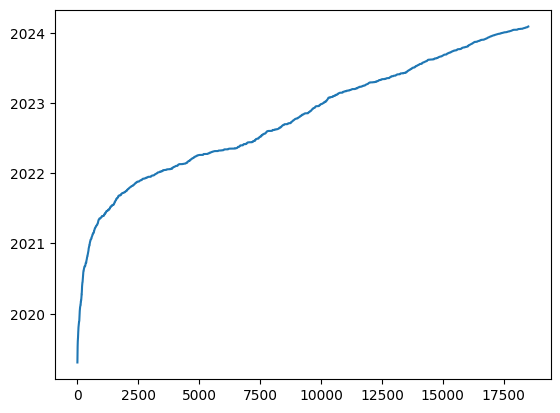

In [11]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

df = df.sort_values('time')
# do not consider the last signals - they may contain erroneus signals
df = df[df['time'] < df['time'].max()].reset_index(drop=True)

df['time'].plot()


# Visualize feature distributions

In [12]:
# import seaborn as sns

# fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
# cols = [c for c in fi if 'prev' not in c]
# figsize = (20, 30)

# def plot_target_violine(df, df_cols, n_rows, n_cols, target):
#     fig = plt.figure(figsize=figsize)
    
#     for idx, col in enumerate(df_cols):
#         ax = plt.subplot(n_rows, n_cols, idx + 1)
#         sns.violinplot(x=target, y=col, data=df)

#         ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
#         ax.set_xlabel(''); ax.spines['right'].set_visible(False)
#         ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
#     fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
#     # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
#     plt.tight_layout()
#     plt.show()
    
# plot_target_violine(df, cols, n_rows=7, n_cols=3, target='target') 

# Check the last signals

In [13]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
# x = x[x['time'].dt.hour.isin([3, 7, 11, 15, 19, 23])]
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
54280,2024-02-05 00:00:00,WINGUSDT,buy,STOCH_RSI_Volume24
54281,2024-02-05 00:00:00,FARUSDT,buy,STOCH_RSI_Volume24
54282,2024-02-05 01:00:00,ARDRUSDT,buy,STOCH_RSI_Volume24
54283,2024-02-05 02:00:00,FORUSDT,buy,STOCH_RSI_Volume24
54284,2024-02-05 03:00:00,PYRUSDT,buy,STOCH_RSI_Volume24
54285,2024-02-05 04:00:00,SOGEUSDT,buy,STOCH_RSI_Volume24
54286,2024-02-05 06:00:00,SANTOSUSDT,buy,STOCH_RSI_Volume24
54287,2024-02-05 06:00:00,WINGUSDT,buy,STOCH_RSI_Volume24
54288,2024-02-05 06:00:00,VITEUSDT,buy,STOCH_RSI_Volume24
54289,2024-02-05 06:00:00,XTZUSDT,buy,STOCH_RSI_Volume24


# Select features with BORUTA feature importance

In [14]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=300)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(df)

# Select features with permutation importance and GBM feature importance

In [15]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# RFE feature selection

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(df)

# Combine importances and save them

In [17]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

# Prepare features

In [18]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

df['weekday'] = df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 58
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['stoch_diff',
 'stoch_slowk',
 'low',
 'open',
 'rsi',
 'close',
 'btcdom_high',
 'btcdom_open',
 'high',
 'close_prev_4',
 'btcd_high_prev_8',
 'stoch_slowk_prev_8',
 'rsi_prev_8',
 'high_prev_12',
 'atr_prev_20',
 'high_prev_24',
 'btcd_volume_prev_24',
 'btcd_volume_prev_28',
 'stoch_slowk_prev_28',
 'btcd_volume_prev_32',
 'btcd_high_prev_32',
 'close_prev_36',
 'low_prev_36',
 'btcd_volume_prev_40',
 'btcdom_volume_prev_48',
 'stoch_diff_prev_52',
 'btcd_volume_prev_56',
 'btcd_volume_prev_64',
 'high_prev_68',
 'btcd_open_prev_80',
 'btcd_volume_prev_80',
 'atr_prev_80',
 'close_prev_88',
 'low_prev_88',
 'btcdom_volume_prev_96',
 'rsi_prev_100',
 'btcd_volume_prev_100',
 'btcd_volume_prev_104',
 'close_prev_104',
 'btcd_volume_prev_120',
 'btcd_volume_prev_124',
 'stoch_diff_prev_136',
 'atr_prev_140',
 'stoch_slowd_prev_140',
 'btcd_open_prev_140',
 'high_prev_144',
 'btcdom_volume_prev_144',
 'btcd_volume_prev_148',
 'stoch_diff_prev_168',
 'close_prev_172',
 'atr_prev_176',


# Remove features that correlate with other features too much and are not so important

In [19]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Functions for train and optimization

In [20]:
import math
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

val_idxs = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(train_df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = train_df[features], train_df['time']
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (train_df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(train_df.loc[val_idx[0], 'time'])
                display(train_df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round(prec_obj_num * prec_score - prec_obj_num * (1 -prec_score))}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = train_df[features], train_df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([train_df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    df['weekday'] = df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res
    

# Train / optimize

In [22]:
params = {
    'boosting_type': 'dart',
    'n_estimators': 3000,
    'learning_rate': 0.009347007927895367,
    'max_depth': 4,
    'colsample_bytree': 0.7276805136510858,
    'subsample': 0.8176913485342896,
    'subsample_freq': 1,
    'num_leaves': 386,
    'verbosity': -1,
    'max_bin': 149,
    'reg_alpha': 0.007990719917791714,
    'reg_lambda': 2.1252342830587052e-05,
    # 'is_unbalance': True,
    # 'class_weight': 'balanced',
    'objective': 'binary',
    'importance_type': 'gain'
    }

# params = {
#     'boosting_type': 'gbdt',
#     'n_estimators': 2387,
#     'learning_rate': 0.002113971011944,
#     'max_depth': 7,
#     'colsample_bytree': 0.8737441804790338,
#     'subsample': 0.7484770798064527,
#     'subsample_freq': 1,
#     'num_leaves': 448,
#     'verbosity': -1,
#     'max_bin': 124,
#     'reg_alpha': 9.333639309604772,
#     'reg_lambda': 3.966019436205039e-08,
#     'is_unbalance': True,
#     'class_weight': 'balanced',
#     'objective': 'binary',
#     # 'metric': 'average_precision',
#     'importance_type': 'gain'
#     }

train_test = 'fold' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(df, features, params, n_folds=5, low_bound=low_bound, high_bound=high_bound, 
                                       train_test=train_test, verbose=True)
    y = df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))}')
elif train_test == 'full':
    oof, model, val_idxs = model_train(df[df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                        high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 59 features
Fold #1


1    0.557387
0    0.442613
Name: target, dtype: float64

Timestamp('2022-05-10 03:00:00')

Timestamp('2024-02-04 15:00:00')

[100]	training's binary_logloss: 0.657514	valid_1's binary_logloss: 0.685622
[200]	training's binary_logloss: 0.644565	valid_1's binary_logloss: 0.685852
[300]	training's binary_logloss: 0.631296	valid_1's binary_logloss: 0.686702
[400]	training's binary_logloss: 0.620081	valid_1's binary_logloss: 0.686782
[500]	training's binary_logloss: 0.608972	valid_1's binary_logloss: 0.687771
[600]	training's binary_logloss: 0.604934	valid_1's binary_logloss: 0.688041
[700]	training's binary_logloss: 0.596778	valid_1's binary_logloss: 0.689453
[800]	training's binary_logloss: 0.591511	valid_1's binary_logloss: 0.689123
[900]	training's binary_logloss: 0.584374	valid_1's binary_logloss: 0.689269
[1000]	training's binary_logloss: 0.57986	valid_1's binary_logloss: 0.689037
[1100]	training's binary_logloss: 0.574472	valid_1's binary_logloss: 0.689369
[1200]	training's binary_logloss: 0.571497	valid_1's binary_logloss: 0.689779
[1300]	training's binary_logloss: 0.56713	valid_1's binary_logloss: 0.6898

1    0.563331
0    0.436669
Name: target, dtype: float64

Timestamp('2022-09-20 21:00:00')

Timestamp('2024-02-04 15:00:00')

[100]	training's binary_logloss: 0.666154	valid_1's binary_logloss: 0.685753
[200]	training's binary_logloss: 0.655187	valid_1's binary_logloss: 0.686484
[300]	training's binary_logloss: 0.643489	valid_1's binary_logloss: 0.686192
[400]	training's binary_logloss: 0.633129	valid_1's binary_logloss: 0.686796
[500]	training's binary_logloss: 0.623524	valid_1's binary_logloss: 0.686819
[600]	training's binary_logloss: 0.619568	valid_1's binary_logloss: 0.686095
[700]	training's binary_logloss: 0.612872	valid_1's binary_logloss: 0.686829
[800]	training's binary_logloss: 0.608032	valid_1's binary_logloss: 0.687335
[900]	training's binary_logloss: 0.60125	valid_1's binary_logloss: 0.688058
[1000]	training's binary_logloss: 0.597078	valid_1's binary_logloss: 0.68813
[1100]	training's binary_logloss: 0.59197	valid_1's binary_logloss: 0.688924
[1200]	training's binary_logloss: 0.589096	valid_1's binary_logloss: 0.689369
[1300]	training's binary_logloss: 0.584942	valid_1's binary_logloss: 0.68925

1    0.549547
0    0.450453
Name: target, dtype: float64

Timestamp('2023-03-11 21:00:00')

Timestamp('2024-02-04 15:00:00')

[100]	training's binary_logloss: 0.668107	valid_1's binary_logloss: 0.685754
[200]	training's binary_logloss: 0.659745	valid_1's binary_logloss: 0.685444
[300]	training's binary_logloss: 0.650261	valid_1's binary_logloss: 0.685227
[400]	training's binary_logloss: 0.642819	valid_1's binary_logloss: 0.685108
[500]	training's binary_logloss: 0.634132	valid_1's binary_logloss: 0.686812
[600]	training's binary_logloss: 0.630986	valid_1's binary_logloss: 0.687066
[700]	training's binary_logloss: 0.625025	valid_1's binary_logloss: 0.687358
[800]	training's binary_logloss: 0.621042	valid_1's binary_logloss: 0.687584
[900]	training's binary_logloss: 0.615112	valid_1's binary_logloss: 0.688733
[1000]	training's binary_logloss: 0.61106	valid_1's binary_logloss: 0.688905
[1100]	training's binary_logloss: 0.606813	valid_1's binary_logloss: 0.689754
[1200]	training's binary_logloss: 0.604164	valid_1's binary_logloss: 0.690835
[1300]	training's binary_logloss: 0.600544	valid_1's binary_logloss: 0.692

1    0.589754
0    0.410246
Name: target, dtype: float64

Timestamp('2023-06-22 19:00:00')

Timestamp('2024-02-04 15:00:00')

[100]	training's binary_logloss: 0.672909	valid_1's binary_logloss: 0.676552
[200]	training's binary_logloss: 0.665186	valid_1's binary_logloss: 0.679474
[300]	training's binary_logloss: 0.656544	valid_1's binary_logloss: 0.68334
[400]	training's binary_logloss: 0.648919	valid_1's binary_logloss: 0.68748
[500]	training's binary_logloss: 0.641037	valid_1's binary_logloss: 0.691167
[600]	training's binary_logloss: 0.637627	valid_1's binary_logloss: 0.694438
[700]	training's binary_logloss: 0.632405	valid_1's binary_logloss: 0.698666
[800]	training's binary_logloss: 0.628814	valid_1's binary_logloss: 0.701243
[900]	training's binary_logloss: 0.623698	valid_1's binary_logloss: 0.70522
[1000]	training's binary_logloss: 0.619943	valid_1's binary_logloss: 0.705746
[1100]	training's binary_logloss: 0.615452	valid_1's binary_logloss: 0.705504
[1200]	training's binary_logloss: 0.612724	valid_1's binary_logloss: 0.705265
[1300]	training's binary_logloss: 0.609414	valid_1's binary_logloss: 0.70580

1    0.581911
0    0.418089
Name: target, dtype: float64

Timestamp('2023-10-30 01:00:00')

Timestamp('2024-02-04 15:00:00')

[100]	training's binary_logloss: 0.673649	valid_1's binary_logloss: 0.683866
[200]	training's binary_logloss: 0.666813	valid_1's binary_logloss: 0.684582
[300]	training's binary_logloss: 0.658946	valid_1's binary_logloss: 0.684429
[400]	training's binary_logloss: 0.652132	valid_1's binary_logloss: 0.684282
[500]	training's binary_logloss: 0.644944	valid_1's binary_logloss: 0.683966
[600]	training's binary_logloss: 0.642376	valid_1's binary_logloss: 0.683088
[700]	training's binary_logloss: 0.637296	valid_1's binary_logloss: 0.684171
[800]	training's binary_logloss: 0.633753	valid_1's binary_logloss: 0.683781
[900]	training's binary_logloss: 0.628631	valid_1's binary_logloss: 0.683618
[1000]	training's binary_logloss: 0.625795	valid_1's binary_logloss: 0.684736
[1100]	training's binary_logloss: 0.621686	valid_1's binary_logloss: 0.68503
[1200]	training's binary_logloss: 0.619056	valid_1's binary_logloss: 0.685423
[1300]	training's binary_logloss: 0.615902	valid_1's binary_logloss: 0.685

In [23]:
# Training with 76 features
# Fold #1
# 1    0.557387
# 0    0.442613
# Name: target, dtype: float64Timestamp('2022-05-10 03:00:00')Timestamp('2024-02-04 15:00:00')
# [100]	training's binary_logloss: 0.667381	valid_1's binary_logloss: 0.692285
# [200]	training's binary_logloss: 0.646303	valid_1's binary_logloss: 0.692283
# [300]	training's binary_logloss: 0.629228	valid_1's binary_logloss: 0.693273
# [400]	training's binary_logloss: 0.614922	valid_1's binary_logloss: 0.694538
# [500]	training's binary_logloss: 0.602086	valid_1's binary_logloss: 0.695625
# [600]	training's binary_logloss: 0.590774	valid_1's binary_logloss: 0.696789
# [700]	training's binary_logloss: 0.580341	valid_1's binary_logloss: 0.697599
# [800]	training's binary_logloss: 0.570555	valid_1's binary_logloss: 0.698311
# [900]	training's binary_logloss: 0.561544	valid_1's binary_logloss: 0.69904
# [1000]	training's binary_logloss: 0.553079	valid_1's binary_logloss: 0.699771
# [1100]	training's binary_logloss: 0.545233	valid_1's binary_logloss: 0.700545
# [1200]	training's binary_logloss: 0.537818	valid_1's binary_logloss: 0.701127
# [1300]	training's binary_logloss: 0.530348	valid_1's binary_logloss: 0.701508
# [1400]	training's binary_logloss: 0.523302	valid_1's binary_logloss: 0.701965
# [1500]	training's binary_logloss: 0.516513	valid_1's binary_logloss: 0.702478
# [1600]	training's binary_logloss: 0.509893	valid_1's binary_logloss: 0.702915
# [1700]	training's binary_logloss: 0.503485	valid_1's binary_logloss: 0.703389
# [1800]	training's binary_logloss: 0.497333	valid_1's binary_logloss: 0.703618
# [1900]	training's binary_logloss: 0.491348	valid_1's binary_logloss: 0.704275
# [2000]	training's binary_logloss: 0.485631	valid_1's binary_logloss: 0.704598
# [2100]	training's binary_logloss: 0.480061	valid_1's binary_logloss: 0.704954
# [2200]	training's binary_logloss: 0.474625	valid_1's binary_logloss: 0.705246
# [2300]	training's binary_logloss: 0.469264	valid_1's binary_logloss: 0.705624
# Logloss: 0.7058002295709649, Confident objects precision: 0.5806132542037586
# Number of confident objects 3033, % of confident objects: 0.47621290626471974
# Number of profitable objects: 489
# Fold #2
# 1    0.563331
# 0    0.436669
# Name: target, dtype: float64Timestamp('2022-09-20 21:00:00')Timestamp('2024-02-04 15:00:00')
# [100]	training's binary_logloss: 0.669827	valid_1's binary_logloss: 0.690939
# [200]	training's binary_logloss: 0.650949	valid_1's binary_logloss: 0.690062
# [300]	training's binary_logloss: 0.635616	valid_1's binary_logloss: 0.689895
# [400]	training's binary_logloss: 0.622435	valid_1's binary_logloss: 0.690189
# [500]	training's binary_logloss: 0.610832	valid_1's binary_logloss: 0.690578
# [600]	training's binary_logloss: 0.600472	valid_1's binary_logloss: 0.691395
# [700]	training's binary_logloss: 0.590817	valid_1's binary_logloss: 0.691979
# [800]	training's binary_logloss: 0.582034	valid_1's binary_logloss: 0.692556
# [900]	training's binary_logloss: 0.573774	valid_1's binary_logloss: 0.692993
# [1000]	training's binary_logloss: 0.566047	valid_1's binary_logloss: 0.693477
# [1100]	training's binary_logloss: 0.558834	valid_1's binary_logloss: 0.693796
# [1200]	training's binary_logloss: 0.55191	valid_1's binary_logloss: 0.694147
# [1300]	training's binary_logloss: 0.544955	valid_1's binary_logloss: 0.694463
# [1400]	training's binary_logloss: 0.538458	valid_1's binary_logloss: 0.69478
# [1500]	training's binary_logloss: 0.532201	valid_1's binary_logloss: 0.695032
# [1600]	training's binary_logloss: 0.526134	valid_1's binary_logloss: 0.695289
# [1700]	training's binary_logloss: 0.520145	valid_1's binary_logloss: 0.695651
# [1800]	training's binary_logloss: 0.51446	valid_1's binary_logloss: 0.695814
# [1900]	training's binary_logloss: 0.508918	valid_1's binary_logloss: 0.695907
# [2000]	training's binary_logloss: 0.503551	valid_1's binary_logloss: 0.696247
# [2100]	training's binary_logloss: 0.49822	valid_1's binary_logloss: 0.696341
# [2200]	training's binary_logloss: 0.493023	valid_1's binary_logloss: 0.696737
# [2300]	training's binary_logloss: 0.48801	valid_1's binary_logloss: 0.696854
# Logloss: 0.6969614060442753, Confident objects precision: 0.5945945945945946
# Number of confident objects 2553, % of confident objects: 0.49219201850780797
# Number of profitable objects: 483
# Fold #3
# 1    0.549547
# 0    0.450453
# Name: target, dtype: float64Timestamp('2023-03-11 21:00:00')Timestamp('2024-02-04 15:00:00')
# [100]	training's binary_logloss: 0.672387	valid_1's binary_logloss: 0.693092
# [200]	training's binary_logloss: 0.65566	valid_1's binary_logloss: 0.693434
# [300]	training's binary_logloss: 0.641735	valid_1's binary_logloss: 0.693711
# [400]	training's binary_logloss: 0.629486	valid_1's binary_logloss: 0.693887
# [500]	training's binary_logloss: 0.618691	valid_1's binary_logloss: 0.694139
# [600]	training's binary_logloss: 0.609135	valid_1's binary_logloss: 0.694093
# [700]	training's binary_logloss: 0.600408	valid_1's binary_logloss: 0.694434
# [800]	training's binary_logloss: 0.592544	valid_1's binary_logloss: 0.69448
# [900]	training's binary_logloss: 0.585097	valid_1's binary_logloss: 0.694528
# [1000]	training's binary_logloss: 0.577827	valid_1's binary_logloss: 0.694522
# [1100]	training's binary_logloss: 0.571152	valid_1's binary_logloss: 0.694491
# [1200]	training's binary_logloss: 0.564612	valid_1's binary_logloss: 0.69445
# [1300]	training's binary_logloss: 0.558157	valid_1's binary_logloss: 0.694401
# [1400]	training's binary_logloss: 0.552077	valid_1's binary_logloss: 0.694559
# [1500]	training's binary_logloss: 0.54623	valid_1's binary_logloss: 0.694584
# [1600]	training's binary_logloss: 0.540439	valid_1's binary_logloss: 0.694592
# [1700]	training's binary_logloss: 0.534746	valid_1's binary_logloss: 0.694546
# [1800]	training's binary_logloss: 0.529508	valid_1's binary_logloss: 0.694554
# [1900]	training's binary_logloss: 0.524232	valid_1's binary_logloss: 0.694513
# [2000]	training's binary_logloss: 0.519054	valid_1's binary_logloss: 0.69441
# [2100]	training's binary_logloss: 0.5142	valid_1's binary_logloss: 0.694537
# [2200]	training's binary_logloss: 0.509139	valid_1's binary_logloss: 0.694536
# [2300]	training's binary_logloss: 0.504314	valid_1's binary_logloss: 0.694764
# Logloss: 0.6949241408189364, Confident objects precision: 0.5855472901168969
# Number of confident objects 1882, % of confident objects: 0.4869340232858991
# Number of profitable objects: 322
# Fold #4
# 1    0.589754
# 0    0.410246
# Name: target, dtype: float64Timestamp('2023-06-22 19:00:00')Timestamp('2024-02-04 15:00:00')
# [100]	training's binary_logloss: 0.675365	valid_1's binary_logloss: 0.69402
# [200]	training's binary_logloss: 0.660389	valid_1's binary_logloss: 0.694512
# [300]	training's binary_logloss: 0.647038	valid_1's binary_logloss: 0.694639
# [400]	training's binary_logloss: 0.635694	valid_1's binary_logloss: 0.695146
# [500]	training's binary_logloss: 0.625552	valid_1's binary_logloss: 0.695369
# [600]	training's binary_logloss: 0.616518	valid_1's binary_logloss: 0.695535
# [700]	training's binary_logloss: 0.607911	valid_1's binary_logloss: 0.695975
# [800]	training's binary_logloss: 0.600029	valid_1's binary_logloss: 0.696033
# [900]	training's binary_logloss: 0.592591	valid_1's binary_logloss: 0.695998
# [1000]	training's binary_logloss: 0.585663	valid_1's binary_logloss: 0.696138
# [1100]	training's binary_logloss: 0.579237	valid_1's binary_logloss: 0.696079
# [1200]	training's binary_logloss: 0.572945	valid_1's binary_logloss: 0.696009
# [1300]	training's binary_logloss: 0.566794	valid_1's binary_logloss: 0.696011
# [1400]	training's binary_logloss: 0.560784	valid_1's binary_logloss: 0.69617
# [1500]	training's binary_logloss: 0.555255	valid_1's binary_logloss: 0.696247
# [1600]	training's binary_logloss: 0.549846	valid_1's binary_logloss: 0.696431
# [1700]	training's binary_logloss: 0.54459	valid_1's binary_logloss: 0.696178
# [1800]	training's binary_logloss: 0.539478	valid_1's binary_logloss: 0.69661
# [1900]	training's binary_logloss: 0.53464	valid_1's binary_logloss: 0.696347
# [2000]	training's binary_logloss: 0.529686	valid_1's binary_logloss: 0.696477
# [2100]	training's binary_logloss: 0.525326	valid_1's binary_logloss: 0.69667
# [2200]	training's binary_logloss: 0.520815	valid_1's binary_logloss: 0.696904
# [2300]	training's binary_logloss: 0.516459	valid_1's binary_logloss: 0.696879
# Logloss: 0.6968977812867044, Confident objects precision: 0.6073903002309469
# Number of confident objects 1299, % of confident objects: 0.5080172076652327
# Number of profitable objects: 279
# Fold #5
# 1    0.581911
# 0    0.418089
# Name: target, dtype: float64Timestamp('2023-10-30 01:00:00')Timestamp('2024-02-04 15:00:00')
# [100]	training's binary_logloss: 0.676141	valid_1's binary_logloss: 0.696922
# [200]	training's binary_logloss: 0.662292	valid_1's binary_logloss: 0.700202
# [300]	training's binary_logloss: 0.650561	valid_1's binary_logloss: 0.703202
# [400]	training's binary_logloss: 0.640378	valid_1's binary_logloss: 0.705662
# [500]	training's binary_logloss: 0.631109	valid_1's binary_logloss: 0.707327
# [600]	training's binary_logloss: 0.622747	valid_1's binary_logloss: 0.708983
# [700]	training's binary_logloss: 0.615055	valid_1's binary_logloss: 0.710329
# [800]	training's binary_logloss: 0.608042	valid_1's binary_logloss: 0.711826
# [900]	training's binary_logloss: 0.601511	valid_1's binary_logloss: 0.71254
# [1000]	training's binary_logloss: 0.595103	valid_1's binary_logloss: 0.713757
# [1100]	training's binary_logloss: 0.589173	valid_1's binary_logloss: 0.714451
# [1200]	training's binary_logloss: 0.583491	valid_1's binary_logloss: 0.715166
# [1300]	training's binary_logloss: 0.577725	valid_1's binary_logloss: 0.71578
# [1400]	training's binary_logloss: 0.572407	valid_1's binary_logloss: 0.716556
# [1500]	training's binary_logloss: 0.567182	valid_1's binary_logloss: 0.717312
# [1600]	training's binary_logloss: 0.562111	valid_1's binary_logloss: 0.718077
# [1700]	training's binary_logloss: 0.55709	valid_1's binary_logloss: 0.718701
# [1800]	training's binary_logloss: 0.552381	valid_1's binary_logloss: 0.718954
# [1900]	training's binary_logloss: 0.547781	valid_1's binary_logloss: 0.719226
# [2000]	training's binary_logloss: 0.543327	valid_1's binary_logloss: 0.7197
# [2100]	training's binary_logloss: 0.539124	valid_1's binary_logloss: 0.720127
# [2200]	training's binary_logloss: 0.534825	valid_1's binary_logloss: 0.720772
# [2300]	training's binary_logloss: 0.530539	valid_1's binary_logloss: 0.721132
# Logloss: 0.7217299424476883, Confident objects precision: 0.6372093023255814
# Number of confident objects 215, % of confident objects: 0.18344709897610922
# Number of profitable objects: 59
# Total fold Logloss: 0.699607681272698, Total confident objects precision: 0.619894099848714
# Number of confident objects: 2644, Total % of confident objects: 0.41513581409954464
# Number of profitable objects: 634

# Check model predictions

In [24]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = df[(df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']] #  
    display(res['target'].value_counts(normalize=True))

# Display PR curve

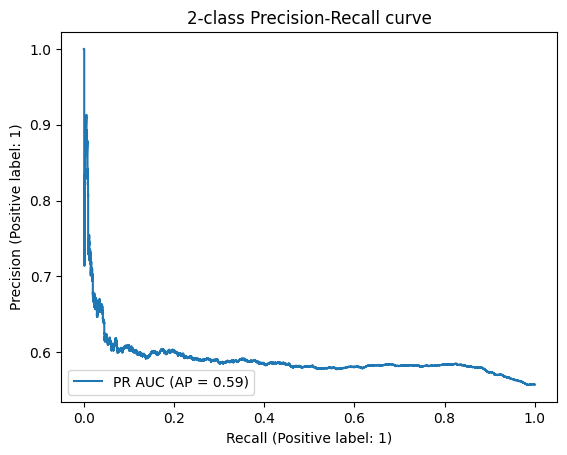

In [25]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.61

# Find the best threshold

ic| bound: 0.3
    prec_score: 0.55745
    obj_num: 6345
    obj_pct: 1.0
    obj_profit: 729
ic| bound: 0.31
    prec_score: 0.55768
    obj_num: 6337
    obj_pct: 0.99
    obj_profit: 731
ic| bound: 0.32
    prec_score: 0.55749
    obj_num: 6323
    obj_pct: 0.99
    obj_profit: 727
ic| bound: 0.33
    prec_score: 0.55707
    obj_num: 6299
    obj_pct: 0.99
    obj_profit: 719
ic| bound: 0.34
    prec_score: 0.55678
    obj_num: 6270
    obj_pct: 0.98
    obj_profit: 712
ic| bound: 0.35
    prec_score: 0.55769
    obj_num: 6240
    obj_pct: 0.98
    obj_profit: 720
ic| bound: 0.36
    prec_score: 0.55925
    obj_num: 6194
    obj_pct: 0.97
    obj_profit: 734
ic| bound: 0.37
    prec_score: 0.56081
    obj_num: 6150
    obj_pct: 0.97
    obj_profit: 748
ic| bound: 0.38
    prec_score: 0.56191
    obj_num: 6106
    obj_pct: 0.96
    obj_profit: 756
ic| bound: 0.39
    prec_score: 0.5631
    obj_num: 6054
    obj_pct: 0.95
    obj_profit: 764
ic| bound: 0.4
    prec_score: 0.56415
    

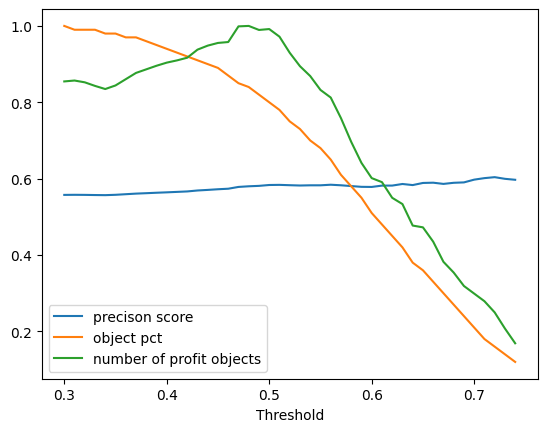

In [26]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round(obj_num * prec_score - obj_num * (1 - prec_score))
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct')
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()